In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from helpers import get_inverse_var_pf, get_distance_matrix, quasi_diagonalize, get_cluster_var, get_hrp_allocation

### Engineered Features

In [2]:
# Loading the data
data = pd.read_csv('./data/featureset.csv')
data.date = pd.to_datetime(data.date)
data.set_index(["ticker","date"], inplace=True)
data.dropna(inplace=True)

In [4]:
# Specifying features and targets
X, y = data.iloc[:,:-6], data.iloc[:,-6:]

In [7]:
# Standardising features
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.copy()), columns=X.columns, index=X.index)
data = pd.concat([X,y], axis=1)
data.dropna(inplace=True)
X, y = data.iloc[:,:-6], data.iloc[:,-6:]

In [8]:
# Covariance matrix for features
cov_mat = np.cov(X.T)
cov_mat
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(cov_mat.shape)

(71, 71)


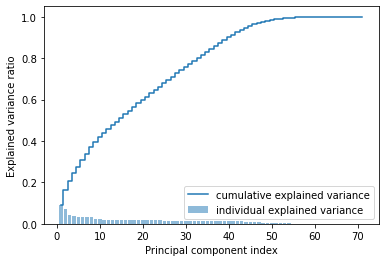

In [12]:
# Identifying number of features to keep
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1,72), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,72), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [15]:
# Applying PCA on engineered features
pca = PCA(n_components=30)
datapca = pca.fit_transform(X=X)
datapca = pd.DataFrame(datapca, index=X.index)
datapca

0         1         2         3         4         5   \
ticker date                                                                     
A      2015-01-02 -1.134655  0.696338  0.907761 -0.753200 -0.362249  1.128555   
       2015-01-05 -1.315088  1.627848  0.944224 -0.735194 -0.381408  0.650096   
       2015-01-06 -1.427909  2.111445  1.085764 -0.819097 -0.736291  0.246031   
       2015-01-07 -1.273737  1.401048  1.141920 -0.717778 -0.714827  0.235786   
       2015-01-08 -1.091656  0.446711  0.272174 -0.449557 -0.010495  0.931516   
...                     ...       ...       ...       ...       ...       ...   
ZTS    2020-09-25  1.073896 -0.121675  1.271522 -0.565871  2.227659 -0.064665   
       2020-09-28  1.139693 -0.148064  1.359329 -0.450579  1.850448  0.003951   
       2020-09-29  1.125364 -0.311595  0.917056 -0.489918  2.045313  0.142107   
       2020-09-30  1.284682 -0.800284  0.521427 -0.152514  2.614233  0.488825   
       2020-10-01  1.085607 -0.607896 -0.343978 -0.278352  1.947697 -0.620164   

                         6         7         8         9   ...        20  \
ticker date                                                ...             
A      2015-01-02 -0.935792 -0.525319  0.450803  0.352753  ...  0.655906   
       2015-01-05 -0.076584 -0.368973  0.530891  0.360874  ...  0.680676   
       2015-01-06  0.244985 -0.017423  0.540911  0.333807  ...  0.664219   
       2015-01-07  0.527922 -0.024059  0.259093 -0.148710  ...  0.852573   
       2015-01-08  0.269996 -0.049550  0.205518 -0.618388  ...  0.996207   
...                     ...       ...       ...       ...  ...       ...   
ZTS    2020-09-25 -0.688566  2.779596 -1.531271  0.797054  ...  1.069595   
       2020-09-28 -0.210518  2.327049 -1.519129  0.656232  ...  1.085117   
       2020-09-29 -0.173735  2.386775 -1.279191  0.349710  ...  1.099423   
       2020-09-30 -0.822225  2.767412 -1.336705 -0.053871  ...  0.980781   
       2020-10-01 -1.188798  1.280864 -0.856649 -0.119639  ... -0.038812   

                         21        22        23        24        25        26  \
ticker date                                                                     
A      2015-01-02  1.903829 -0.207710 -1.061914 -0.248991  0.170895  0.245611   
       2015-01-05  1.621388 -0.207258 -1.385820 -0.228787 -0.326660  0.473927   
       2015-01-06  1.780603 -0.267376 -1.271235 -0.349263  0.205092  0.291727   
       2015-01-07  1.580331  0.025147 -1.358445 -0.367124  0.851193  0.052368   
       2015-01-08  1.622939 -0.203301 -1.290532 -0.415469  0.577132  0.099039   
...                     ...       ...       ...       ...       ...       ...   
ZTS    2020-09-25  1.423053 -0.015716 -0.710618  0.366589 -0.915044 -1.781592   
       2020-09-28  1.318134  0.030385 -0.926425  0.116206 -1.346749 -1.647163   
       2020-09-29  1.413009  0.083377 -0.836450  0.115831 -0.524000 -1.959811   
       2020-09-30  1.273016  0.153742 -0.806317  0.479595 -1.010668 -1.745902   
       2020-10-01  2.379490 -0.520637 -0.413606  0.390714 -0.899841 -0.025709   

                         27        28        29  
ticker date                                      
A      2015-01-02  0.805831  0.472056 -0.294345  
       2015-01-05  0.847993  0.382350 -0.513488  
       2015-01-06  1.242589  0.183635 -0.461501  
       2015-01-07  1.532741  0.116445 -0.243816  
       2015-01-08  1.290966  0.191546 -0.459211  
...                     ...       ...       ...  
ZTS    2020-09-25  0.791619  1.089178 -0.139075  
       2020-09-28  0.742566  1.114054 -0.258110  
       2020-09-29  1.270952  0.797876 -0.244951  
       2020-09-30  0.984300  0.935036 -0.233524  
       2020-10-01  1.073443  1.224623  1.272094  

[709062 rows x 30 columns]

In [18]:
# Saving PCA Engineered Feaures
pcafeatures = pd.concat([datapca,y], axis=1)
pcafeatures.to_csv('./data/pcafeatureset.csv')

### Eigenportfolios

In [157]:
# Getting daily returns
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.set_index(['ticker','date'], inplace=True)
returns = ohlcv.sort_index().close.unstack('ticker').pct_change().dropna(how='all')
returns.dropna(axis=1, inplace=True)
returns

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.012631,0.046530,0.028613,-0.021966,0.006156,0.000715,0.007821,0.010725,0.003328,-0.002193,...,-0.000363,-0.007614,-0.002406,0.004796,0.009075,0.006259,0.004337,0.007522,0.007083,-0.009580
2014-01-06,-0.004919,0.018463,-0.009568,0.005453,-0.036520,-0.003574,0.008869,0.013199,-0.010565,-0.017579,...,-0.005455,-0.004384,0.001507,-0.006018,-0.001741,-0.000794,0.006476,-0.003359,-0.007033,-0.002184
2014-01-07,0.014300,-0.004439,0.012344,-0.007151,0.001985,0.010906,0.011722,-0.007663,0.012168,0.014625,...,0.017185,0.002202,0.014148,0.015449,0.002906,0.014040,0.019949,0.010300,0.003035,0.003752
2014-01-08,0.016363,0.026756,-0.007775,0.006333,-0.002575,0.009794,0.022085,0.009009,0.007728,-0.001187,...,-0.003954,0.008567,-0.003265,0.001850,-0.000579,-0.000392,0.024500,-0.000741,0.008742,-0.011215
2014-01-09,0.000343,0.064784,0.011131,-0.012770,0.017077,0.003374,0.046759,0.001785,0.009738,0.003226,...,0.003970,-0.002831,-0.009728,0.003694,0.004059,-0.019339,-0.009853,0.004637,0.007333,0.006931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,0.011122,0.032973,-0.009109,0.010257,0.004545,0.001171,0.010629,-0.003800,0.000812,0.014706,...,-0.022943,0.064116,0.041145,0.002506,0.004788,0.003272,-0.000825,0.012949,0.018192,-0.002801
2021-08-24,0.003353,0.037677,0.000048,-0.000601,0.002681,-0.014037,0.016515,-0.002702,-0.006038,0.000579,...,-0.010146,-0.002801,0.008195,0.009332,0.013313,-0.010082,0.023393,-0.000311,0.017320,-0.007168
2021-08-25,0.016005,0.016137,0.021465,-0.008421,0.006016,0.000763,0.001091,-0.006056,0.007646,-0.000669,...,0.000293,0.001045,0.001806,0.000660,0.010622,0.006740,0.011093,0.009331,0.016846,-0.002732


In [158]:
# Selecting top 100 stocks based on sum of returns
returns = returns.loc[:, list(returns.sum().sort_values(ascending=False)[:100].index)]

C:\Users\Ishan\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


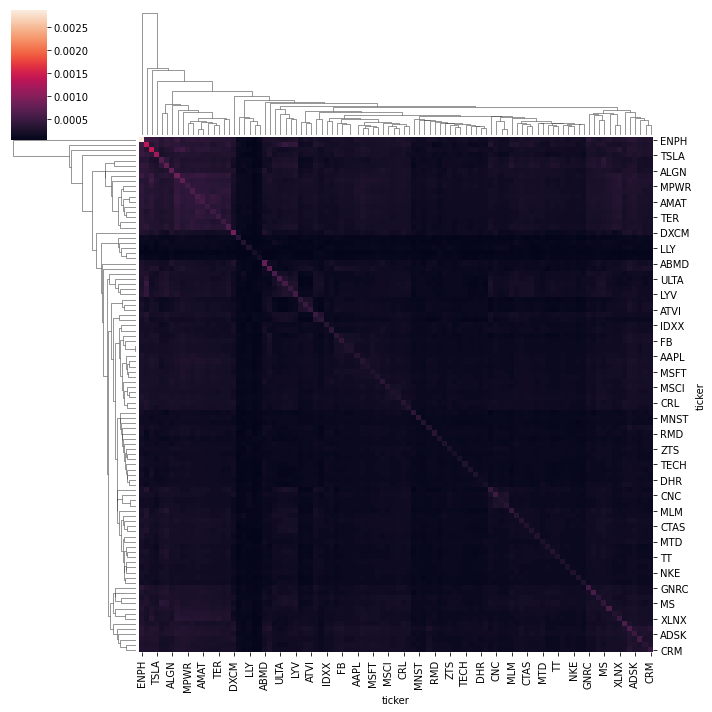

In [159]:
# Covariance for top 100 stocks
cov = returns.cov()
sns.clustermap(cov);

In [160]:
# Identifying principal components of variance
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').style.format('{:,.2%}'.format)

,Explained Variance
0,52.11%
1,12.49%
2,9.87%
3,4.29%
4,2.54%
5,2.36%
6,1.56%
7,1.30%
8,1.08%
9,0.95%


In [161]:
# Using top 4 components to get weights for portfolios
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

In [162]:
# Weights in each portfolio consisting of all 100 stocks
eigen_portfolios

ticker,ENPH,NVDA,AMD,TSLA,DXCM,ABMD,FTNT,MPWR,ALGN,PENN,...,TMO,TYL,MS,MLM,NKE,NEE,MNST,TT,STE,XLNX
0,0.048045,0.019533,0.024720,0.020864,0.009422,0.008121,0.012090,0.018989,0.015059,0.024783,...,0.004538,0.006408,0.011406,0.008380,0.005824,0.000791,0.003990,0.007009,0.005006,0.015321
1,-0.384301,0.057147,0.053649,0.010491,-0.001897,0.009066,0.016854,0.038750,0.013638,-0.000164,...,0.011225,0.007794,0.015339,0.002669,0.005307,-0.002933,0.009787,0.007141,0.003690,0.038709
2,-0.266758,-0.307807,-0.480740,-0.198729,-0.223839,-0.217744,-0.178882,-0.139239,0.086246,0.737024,...,-0.131100,-0.187863,0.314104,0.388625,0.128154,0.024851,-0.005624,0.242406,0.031349,-0.173178
3,-0.083634,-0.029278,-0.126101,0.271672,0.289916,0.134693,0.096731,-0.069238,0.084868,0.373700,...,-0.002071,0.058990,-0.047573,-0.009116,0.010256,-0.009094,0.008298,-0.053240,0.001000,-0.117981


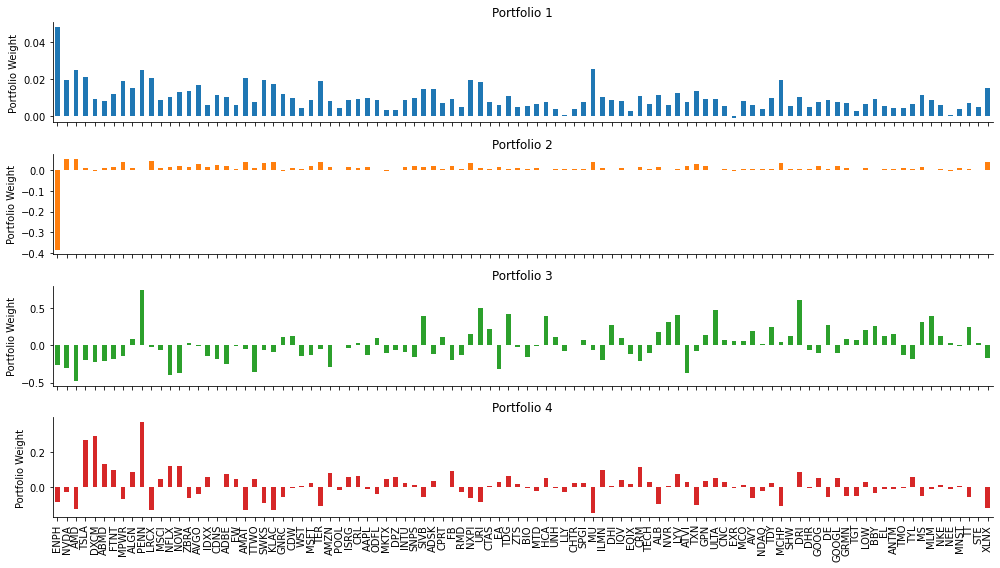

In [163]:
# Plotting weights
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(4, 1),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

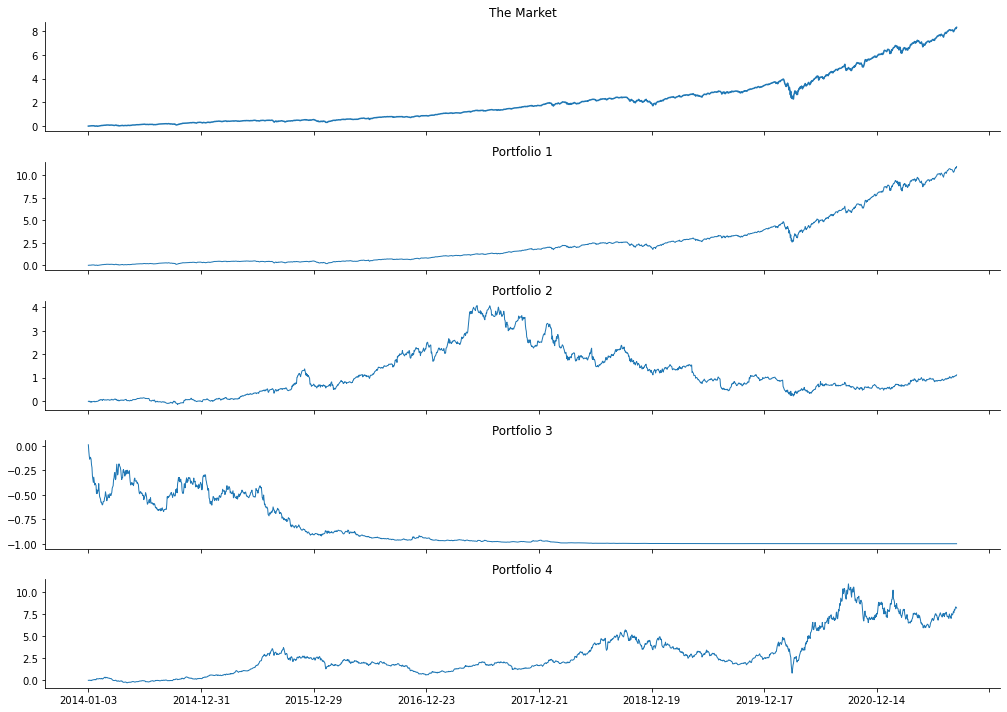

In [165]:
# Comparing performance
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(4):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(5):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

### Hierarchial Risk Parity

In [166]:
# Getting daily returns
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.date = pd.to_datetime(ohlcv.date)
ohlcv.set_index(['ticker','date'], inplace=True)
returns = ohlcv.sort_index().close.unstack('ticker').pct_change().dropna(how='all')
returns.dropna(axis=1, inplace=True)
returns

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.012631,0.046530,0.028613,-0.021966,0.006156,0.000715,0.007821,0.010725,0.003328,-0.002193,...,-0.000363,-0.007614,-0.002406,0.004796,0.009075,0.006259,0.004337,0.007522,0.007083,-0.009580
2014-01-06,-0.004919,0.018463,-0.009568,0.005453,-0.036520,-0.003574,0.008869,0.013199,-0.010565,-0.017579,...,-0.005455,-0.004384,0.001507,-0.006018,-0.001741,-0.000794,0.006476,-0.003359,-0.007033,-0.002184
2014-01-07,0.014300,-0.004439,0.012344,-0.007151,0.001985,0.010906,0.011722,-0.007663,0.012168,0.014625,...,0.017185,0.002202,0.014148,0.015449,0.002906,0.014040,0.019949,0.010300,0.003035,0.003752
2014-01-08,0.016363,0.026756,-0.007775,0.006333,-0.002575,0.009794,0.022085,0.009009,0.007728,-0.001187,...,-0.003954,0.008567,-0.003265,0.001850,-0.000579,-0.000392,0.024500,-0.000741,0.008742,-0.011215
2014-01-09,0.000343,0.064784,0.011131,-0.012770,0.017077,0.003374,0.046759,0.001785,0.009738,0.003226,...,0.003970,-0.002831,-0.009728,0.003694,0.004059,-0.019339,-0.009853,0.004637,0.007333,0.006931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,0.011122,0.032973,-0.009109,0.010257,0.004545,0.001171,0.010629,-0.003800,0.000812,0.014706,...,-0.022943,0.064116,0.041145,0.002506,0.004788,0.003272,-0.000825,0.012949,0.018192,-0.002801
2021-08-24,0.003353,0.037677,0.000048,-0.000601,0.002681,-0.014037,0.016515,-0.002702,-0.006038,0.000579,...,-0.010146,-0.002801,0.008195,0.009332,0.013313,-0.010082,0.023393,-0.000311,0.017320,-0.007168
2021-08-25,0.016005,0.016137,0.021465,-0.008421,0.006016,0.000763,0.001091,-0.006056,0.007646,-0.000669,...,0.000293,0.001045,0.001806,0.000660,0.010622,0.006740,0.011093,0.009331,0.016846,-0.002732


In [168]:
# Covariance and Correlation matrix for daily returns
cov = returns.cov()
corr = returns.corr()
corr.columns.names=['ticker']

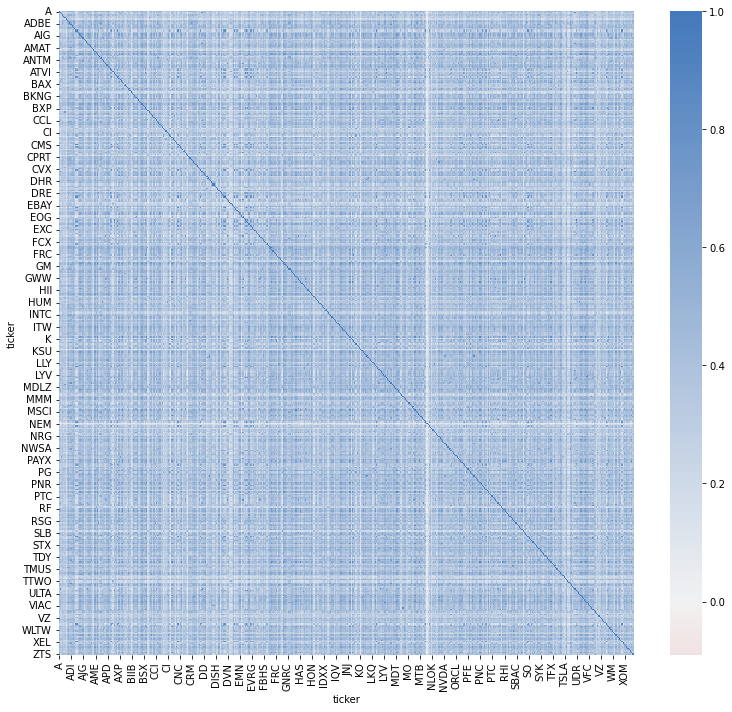

In [169]:
# Plotting Correlation
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()

In [171]:
# Applying Hierarchial Clustering
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')
sorted_idx = quasi_diagonalize(linkage_matrix)

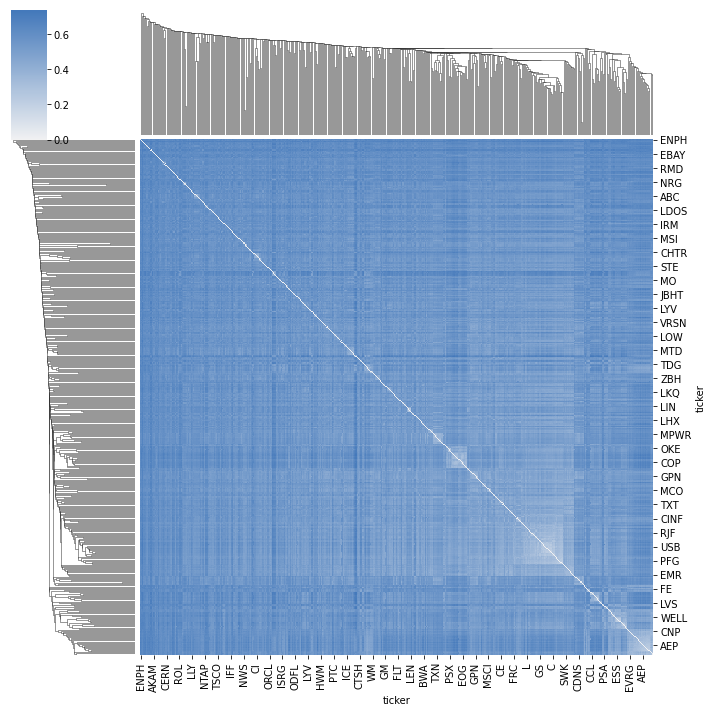

In [172]:
# Plotting Correlation after clustering
clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap, center=0);

In [125]:
# Sorting tickers based on clustering
sorted_idx = clustergrid.dendrogram_row.reordered_ind
sorted_tickers = corr.index[sorted_idx].tolist()

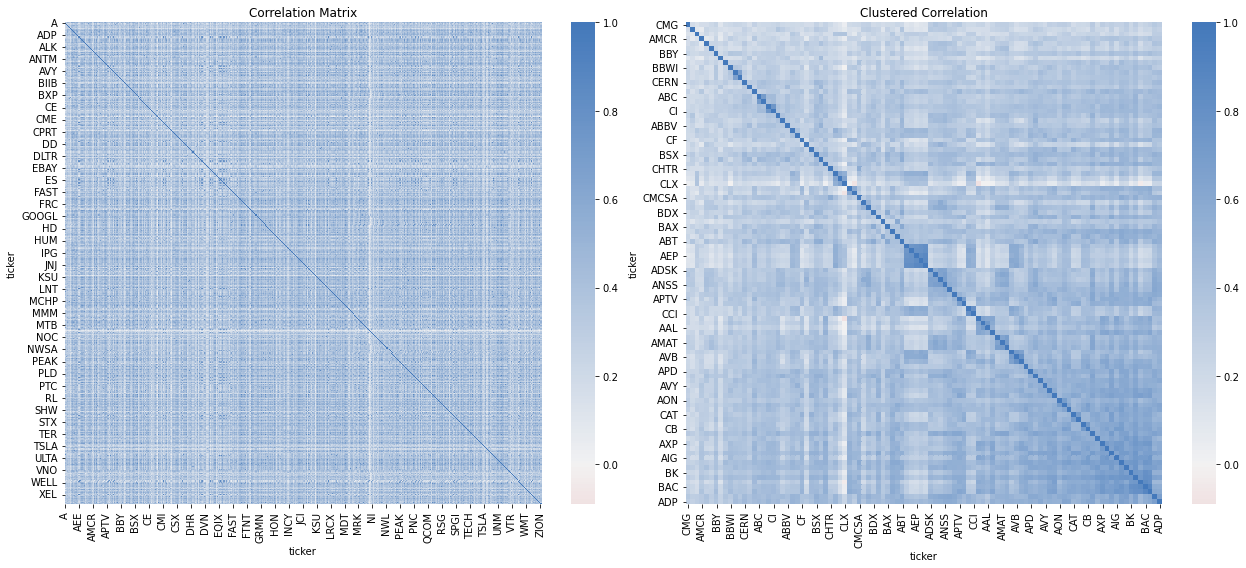

In [173]:
# Visualising Correlation after clustering
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

In [174]:
# Applying Hierarchial CLustering on top 100 stocks based on sum of returns
returns = returns.loc[:, list(returns.sum().sort_values(ascending=False)[:100].index)]
cov = returns.cov()
corr = returns.corr()
corr.columns.names=['ticker']
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')
sorted_idx = quasi_diagonalize(linkage_matrix)

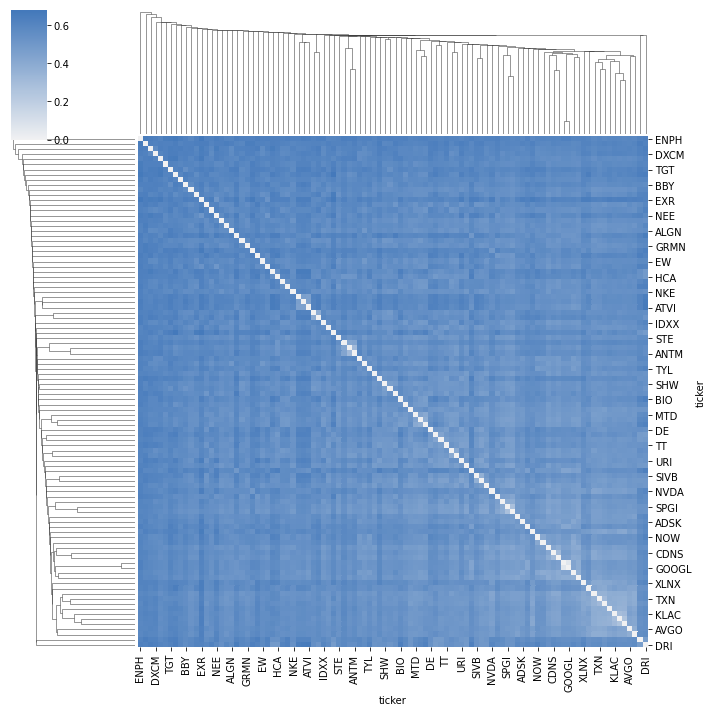

In [175]:
# Plotting Correlation after clustering top 100 stocks
clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap, center=0);

In [176]:
# Sorting top 100 tickers based on clustering
sorted_idx = clustergrid.dendrogram_row.reordered_ind
sorted_tickers = corr.index[sorted_idx].tolist()

In [179]:
# Obtaining weights for top 100 stock basket
hrp_allocation = get_hrp_allocation(cov, sorted_tickers)

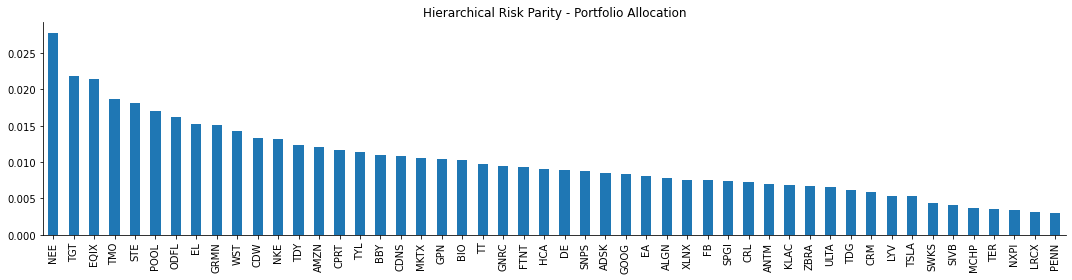

In [180]:
# Plotting weights
title = 'Hierarchical Risk Parity - Portfolio Allocation'
hrp_allocation[:100].sort_values(ascending=False).iloc[::2].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()